In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from sklearn import metrics

In [3]:

# The BuildDataset class consists __init__ that gets the corresponding masks, labels and boxes for each image
# The __getitem__ function uses this data to return transformed image, its masks, labels and bboxes.
# The transformations are normalization of the image and its RGB channels and resizing.
# Corresponding transformations must be done for the masks and bboxes

class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, path):

        # loading the files from their respective paths
        self.bboxes = np.load(path[3], allow_pickle=True)
        self.labels = np.load(path[2], allow_pickle=True)
        self.mask_id = []

        # Getting masks for the corresponding images with one or more objects
        prev_n = 0 
        for i in range(self.labels.shape[0]):
            n = self.labels[i].shape[0]
            self.mask_id.append(list(range(prev_n, prev_n+n)))
            prev_n = list(range(prev_n, prev_n+n))[-1]+1

        hf = h5py.File(path[1], 'r')
        self.masks  = np.array(hf.get('data'))
        
        im = h5py.File(path[0], 'r')
        self.imgs_data = np.array(im.get('data'))
        
    def __getitem__(self, index):

        # normalizing the three channels with mean and standard deviations
        transform = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        img = torch.tensor(self.imgs_data[index].astype(float)).unsqueeze(0)
        
        # Interpolating the image from 300x400 to 800x1066
        transed_img = transform(F.interpolate(img.clone(), size=(800, 1066), mode='nearest').squeeze(0))
        transed_img = F.pad(transed_img, (11,11), 'constant', 0) # padding on both the sides
        
        label = torch.tensor(self.labels[index]) # accessing labels for the image

        # interpolating and padding the masks
        mask_id_list = self.mask_id[index]
        transed_mask = torch.tensor(self.masks[mask_id_list].astype(float)).unsqueeze(0)
        transed_mask = F.interpolate(transed_mask, size=(800, 1066), mode='nearest').squeeze(0)
        transed_mask = F.pad(transed_mask, (11,11), 'constant', 0)

        # Since image is interpolated, the bbox coordinates need to be adjusted
        transed_bbox = np.copy(self.bboxes[index])
        transed_bbox[:, 0] = transed_bbox[:, 0] * (800/300)
        transed_bbox[:, 1] = transed_bbox[:, 1] * (1066/400) + 11
        transed_bbox[:, 2] = transed_bbox[:, 2] * (800/300)        
        transed_bbox[:, 3] = transed_bbox[:, 3] *(1066/400) + 11        
        transed_bbox = torch.tensor(transed_bbox).squeeze(0)
    
        return transed_img, label, transed_mask, transed_bbox
    
    def __len__(self):
        # returns length of the list of images
        return len(self.imgs_data)

In [5]:
# BuildDataLoader : responsible for generating the dataloader
# after collecting the imgs, labels, masks, and bbox list from the collect_fn. 
# The collect_fn is called as a parameter of collate_fn that is used to create the dataloader.

class BuildDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size, shuffle, num_workers):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers

    # used to return the list of all images and their corresponding labels, bboxes and masks
    # Used as a parameter of the collate_fn in the Dataloader
    def collect_fn(self, batch):
        transed_img_list = []
        label_list = []
        transed_mask_list = []
        transed_bbox_list = []

        for transed_img, label, transed_mask, transed_bbox in batch:
            transed_img_list.append(transed_img.unsqueeze(0))
            label_list.append(label)
            transed_mask_list.append(transed_mask)
            transed_bbox_list.append(transed_bbox)

        return transed_img_list, label_list, transed_mask_list, transed_bbox_list
        

    def loader(self):
        # Returns the dataloader of the dataset
        dataloader = DataLoader(dataset=dataset,
                      batch_size=self.batch_size,
                      shuffle=self.shuffle,
                      collate_fn=self.collect_fn, 
                      num_workers = self.num_workers,drop_last=True)
        return dataloader

In [6]:
# This function is meant for visualizing each of the images along with their masks, bboxes, and labels
# The data is preprocessed and passed as arguments to this function for visualization

def visualize(img,label,mask,bbox,req_bbox = True):
  plt.figure()
  ax = plt.gca()

  inv_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
  img2 = inv_transform(img.squeeze(0))
  img2 = np.copy(img2.detach().numpy().transpose(1,2,0))
  
  mask = mask.squeeze(0).cpu().detach().numpy()
  n = label.shape[0] 

  if (req_bbox):
    bbox = bbox.detach().numpy()
    bbox = bbox.reshape(-1, 4)

  for i in range(n):
    clas = label[i]
    mask2 = mask[i]
    
    # classifying the object and adding the respective color to the mask
    if (clas == 1):
      img2[mask2 == 1,2] = 175
      if (req_bbox):
        rect = patches.Rectangle((bbox[i,0],bbox[i,1]),bbox[i,2] - bbox[i,0],bbox[i,3] - bbox[i,1],linewidth=3,edgecolor='b',facecolor='none')

    if (clas == 3):
      img2[mask2 == 1,0] = 175
      if (req_bbox):
        rect = patches.Rectangle((bbox[i,0],bbox[i,1]),bbox[i,2] - bbox[i,0],bbox[i,3] - bbox[i,1],linewidth=3,edgecolor='r',facecolor='none')

    if (clas == 2):
      img2[mask2 == 1,1] = 175
      if (req_bbox):
        rect = patches.Rectangle((bbox[i,0],bbox[i,1]),bbox[i,2] - bbox[i,0],bbox[i,3] - bbox[i,1],linewidth=3,edgecolor='g',facecolor='none')

    if (req_bbox):
      ax.add_patch(rect)

  # showing the mask atop the image
  plt.imshow(img2.astype(int))
  plt.show()

###Enter the path to load the dataset

In [7]:
## Visualize debugging
if __name__ == '__main__':
    # Make a list of all the file paths
    # Change the paths of the "imgs_path", "masks_path", "labels_path" and "bboxes_path" as per your file location
    # Set the batch_size of 5 to generate 5 images. 
    
    imgs_path = '/content/drive/My Drive/UPenn coursework/680/Homework 3a/hw3_mycocodata_img_comp_zlib.h5'
    masks_path = '/content/drive/My Drive/UPenn coursework/680/Homework 3a/hw3_mycocodata_mask_comp_zlib.h5'
    labels_path = '/content/drive/My Drive/UPenn coursework/680/Homework 3a/hw3_mycocodata_labels_comp_zlib.npy'
    bboxes_path = '/content/drive/My Drive/UPenn coursework/680/Homework 3a/hw3_mycocodata_bboxes_comp_zlib.npy'
    
    paths = [imgs_path, masks_path, labels_path, bboxes_path]
   
    # load the data into data.Dataset
    dataset = BuildDataset(paths)


In [8]:
# Creating the train-test split 
full_size = len(dataset)
train_size = int(full_size * 0.8) # set 80% of the dataset as the training data
test_size = full_size - train_size

torch.random.manual_seed(1)     # set seed

# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# push the randomized training data into the dataloader
# Create the train and test dataloaders 
batch_size = 2 # defined as 5 to generate 5 images for visualization
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = test_build_loader.loader()

BACKBONE

In [9]:
import torchvision
import torch


def Resnet50Backbone(checkpoint_file=None, device="cpu", eval=True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)

    if eval == True:
        model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    resnet50_fpn = model.backbone

    if checkpoint_file:
        checkpoint = torch.load(checkpoint_file)

        resnet50_fpn.load_state_dict(checkpoint['backbone'])

    return resnet50_fpn

# if __name__ == '__main__':
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50_fpn = Resnet50Backbone()
resnet50_fpn.eval()


cuda:0


BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1,

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy import ndimage
# from dataset import *
from functools import partial

class SOLOHead(nn.Module):
    def __init__(self,
                 num_classes,
                 device,
                 in_channels=256,
                 seg_feat_channels=256,
                 stacked_convs=7,
                 strides=[8, 8, 16, 32, 32],
                 scale_ranges=((1, 96), (48, 192), (96, 384), (192, 768), (384, 2048)),
                 epsilon=0.2,
                 num_grids=[40, 36, 24, 16, 12],
                 cate_down_pos=0,
                 with_deform=False,
                 mask_loss_cfg=dict(weight=3),
                 cate_loss_cfg=dict(gamma=2,
                                alpha=0.25,
                                weight=1),
                 postprocess_cfg=dict(cate_thresh=0.2,
                                      ins_thresh=0.5,
                                      pre_NMS_num=50,
                                      keep_instance=5,
                                      IoU_thresh=0.5)):
        super(SOLOHead, self).__init__()
        self.num_classes = num_classes
        self.seg_num_grids = num_grids
        self.cate_out_channels = self.num_classes - 1
        self.in_channels = in_channels
        self.seg_feat_channels = seg_feat_channels
        self.stacked_convs = stacked_convs
        self.strides = strides
        self.epsilon = epsilon
        self.cate_down_pos = cate_down_pos
        self.scale_ranges = scale_ranges
        self.with_deform = with_deform

        self.mask_loss_cfg = mask_loss_cfg
        self.cate_loss_cfg = cate_loss_cfg
        self.postprocess_cfg = postprocess_cfg
        self.device = device

        # initialize the layers for cate and mask branch, and initialize the weights
        self._init_layers()
        self._init_weights()
        # meshgrids for diffrent levels
        self.x_01,self.y_01 = torch.meshgrid(torch.linspace(-1,1,100,device=self.device),torch.linspace(-1,1,136,device=self.device))
        self.x_01 = self.x_01.unsqueeze(0).unsqueeze(0).repeat(2,1,1,1)
        self.y_01 = self.y_01.unsqueeze(0).unsqueeze(0).repeat(2,1,1,1)
        
        self.x_2,self.y_2 = torch.meshgrid(torch.linspace(-1,1,50,device=self.device),torch.linspace(-1,1,68,device=self.device))
        self.x_2 = self.x_2.unsqueeze(0).unsqueeze(0).repeat(2,1,1,1)
        self.y_2 = self.y_2.unsqueeze(0).unsqueeze(0).repeat(2,1,1,1)

        self.x_34,self.y_34 = torch.meshgrid(torch.linspace(-1,1,25,device=self.device),torch.linspace(-1,1,34,device=self.device))
        self.x_34 = self.x_34.unsqueeze(0).unsqueeze(0).repeat(2,1,1,1)
        self.y_34 = self.y_34.unsqueeze(0).unsqueeze(0).repeat(2,1,1,1)

        # For target
        self.ins_label_list, self.ins_ind_label_list, self.cate_label_list = [0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]
        self.ins_ind_label = [torch.zeros(self.seg_num_grids[0]**2,device = self.device),
                              torch.zeros(self.seg_num_grids[1]**2,device = self.device),
                              torch.zeros(self.seg_num_grids[2]**2,device = self.device),
                              torch.zeros(self.seg_num_grids[3]**2,device = self.device),
                              torch.zeros(self.seg_num_grids[4]**2,device = self.device)]
        self.cate_label = [torch.zeros(self.seg_num_grids[0],self.seg_num_grids[0],device = self.device),
                           torch.zeros(self.seg_num_grids[1],self.seg_num_grids[1],device = self.device),
                           torch.zeros(self.seg_num_grids[2],self.seg_num_grids[2],device = self.device),
                           torch.zeros(self.seg_num_grids[3],self.seg_num_grids[3],device = self.device),
                           torch.zeros(self.seg_num_grids[4],self.seg_num_grids[4],device = self.device)]

        self.ins_label = [torch.zeros(self.seg_num_grids[0]**2,int (1600/self.strides[0]),int (2176/self.strides[0]),device = self.device),
                          torch.zeros(self.seg_num_grids[1]**2,int (1600/self.strides[1]),int (2176/self.strides[1]),device = self.device),
                          torch.zeros(self.seg_num_grids[2]**2,int (1600/self.strides[2]),int (2176/self.strides[2]),device = self.device),
                          torch.zeros(self.seg_num_grids[3]**2,int (1600/self.strides[3]),int (2176/self.strides[3]),device = self.device),
                          torch.zeros(self.seg_num_grids[4]**2,int (1600/self.strides[4]),int (2176/self.strides[4]),device = self.device)]

    # This function builds network layer for cate and ins branch
    def _init_layers(self):

        num_groups = 32 # groups in groupnorm

        # initial the two branch head modulelist
        self.cate_head = nn.ModuleList()
        self.ins_head = nn.ModuleList()

        # category branch
        cate_cnn = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.GroupNorm(num_groups, 256),
            nn.ReLU())
        
        self.cate_conv_out = nn.Conv2d(256,self.cate_out_channels,3, padding = 1, bias = True)
        self.cate_head = nn.ModuleList([nn.Sequential(nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1, bias = False),nn.GroupNorm(num_groups, 256),nn.ReLU()) for i in range(7)])

        # instance segmentation branch
        self.ins_conv1 = nn.Sequential(
            nn.Conv2d(258, 256, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.GroupNorm(num_groups, 256),
            nn.ReLU())
        
        ins_cnn = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.GroupNorm(num_groups, 256),
            nn.ReLU())
        
        self.ins_head = nn.ModuleList([nn.Sequential(nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1, bias = False),nn.GroupNorm(num_groups, 256),nn.ReLU()) for i in range(6)])  
        self.ins_conv_out = nn.ModuleList([nn.Conv2d(256,i*i, 1, padding =0, bias = True) for i in self.seg_num_grids])      
        
    # This function initializes weights for head network
    def _init_weights(self):

        for i in range(len(self.cate_head)):
            torch.nn.init.xavier_uniform_(self.cate_head[i][0].weight)
        torch.nn.init.xavier_uniform_(self.cate_conv_out.weight)
        self.cate_conv_out.bias.data.fill_(0)
       
        torch.nn.init.xavier_uniform_(self.ins_conv1[0].weight)
        for i in range(len(self.ins_head)):
            torch.nn.init.xavier_uniform_(self.ins_head[i][0].weight)

        for i in range(len(self.ins_conv_out)):
            torch.nn.init.xavier_uniform_(self.ins_conv_out[i].weight)
            self.ins_conv_out[i].bias.data.fill_(0)

    # Upsample/downsample the fpn level for the network
    # Input is the output of the Resnet backbone 
    # This function is called inside the forward function
    def NewFPN(self, fpn_feat_list):

        # fpn_feat_list from backbone RESNET50

        new_fpn_list = [F.interpolate(fpn_feat_list["0"], size=(100, 136), mode='bilinear'),fpn_feat_list["1"],fpn_feat_list["2"],fpn_feat_list["3"],F.interpolate(fpn_feat_list["pool"], size=(25, 34), mode='bilinear')]
        return new_fpn_list

    # Forwards every level in the FPN using MultipApply() which has a map function in it
    # 1. gets the new fpn list of the output of the RESNET backbone  
    # 2. MultiApply is used to compute cate_pred_list, ins_pred_list. Parallel w.r.t. feature level.
    def forward(self,
                fpn_feat_list,
                eval=False):
        new_fpn_list = self.NewFPN(fpn_feat_list)  # stride[8,8,16,32,32]
        quart_shape = [new_fpn_list[0].shape[-2]*2, new_fpn_list[0].shape[-1]*2]  # stride: 4

        cate_pred_list, ins_pred_list = self.MultiApply(self.forward_single_level, new_fpn_list, list(range(len(new_fpn_list))), eval=eval, upsample_shape=quart_shape)

        return cate_pred_list, ins_pred_list

    # This function forwards a single level of fpn_featmap through the network
    # training and inference modes are distinguished using the eval flag
    def forward_single_level(self, fpn_feat, idx, eval=False, upsample_shape=None):

        cate_pred = fpn_feat
        ins_pred = fpn_feat.clone()
        num_grid = self.seg_num_grids[idx]  # current level grid

        # in inference time, upsample the pred to (ori image size/4)
        if eval == True:
            cate_pred = F.interpolate(cate_pred, size=(num_grid,num_grid), mode='bilinear')
            for i in range(len(self.cate_head)):
              cate_pred =  self.cate_head[i](cate_pred)
            cate_pred = torch.sigmoid(self.cate_conv_out(cate_pred))
            cate_pred = self.points_nms(cate_pred).permute(0,2,3,1)

            W = fpn_feat.shape[-1]
            H = fpn_feat.shape[-2]
       
            if (idx == 0 or idx == 1):
              ins_pred = torch.cat((ins_pred,self.x_01,self.y_01),1)
            elif (idx == 2):
              ins_pred = torch.cat((ins_pred,self.x_2,self.y_2),1)
            else:
              ins_pred = torch.cat((ins_pred,self.x_34,self.y_34),1)
            
            ins_pred = self.ins_conv1(ins_pred)
            
            for i in range(len(self.ins_head)):
              ins_pred =  self.ins_head[i](ins_pred)
              
            ins_pred = torch.sigmoid(self.ins_conv_out[idx](ins_pred))
            
            ori_W = upsample_shape[-1]
            ori_H = upsample_shape[-2]
            ins_pred = F.interpolate(ins_pred, size=(ori_H, ori_W), mode='bilinear')
            
        elif eval == False:
            cate_pred = F.interpolate(cate_pred, size=(num_grid,num_grid), mode='bilinear')
            for i in range(len(self.cate_head)):
              cate_pred =  self.cate_head[i](cate_pred)
            cate_pred = torch.sigmoid(self.cate_conv_out(cate_pred))

            W = fpn_feat.shape[-1]
            H = fpn_feat.shape[-2]
            
            if (idx == 0 or idx == 1):
              ins_pred = torch.cat((ins_pred,self.x_01,self.y_01),1)
            elif (idx == 2):
              ins_pred = torch.cat((ins_pred,self.x_2,self.y_2),1)
            else:
              ins_pred = torch.cat((ins_pred,self.x_34,self.y_34),1)
            
            ins_pred = self.ins_conv1(ins_pred)
            
            for i in range(len(self.ins_head)):
              ins_pred =  self.ins_head[i](ins_pred)
                      
            ins_pred = F.interpolate(ins_pred, size=(2*H ,2*W), mode='bilinear')
            ins_pred = torch.sigmoid(self.ins_conv_out[idx](ins_pred))

        return cate_pred, ins_pred

    # Credit to SOLO Author's code
    def points_nms(self, heat, kernel=2):
        hmax = nn.functional.max_pool2d(
            heat, (kernel, kernel), stride=1, padding=1)
        keep = (hmax[:, :, :-1, :-1] == heat).float()
        return heat * keep

    def loss(self,
             cate_pred_list,
             ins_pred_list,
             ins_gts_list,
             ins_ind_gts_list,
             cate_gts_list):
        cate_preds = [cate_pred_level.permute(0,2,3,1).reshape(-1, self.cate_out_channels) for cate_pred_level in cate_pred_list]
        cate_preds = torch.cat(cate_preds,0)
        cate_gts_raw = [torch.cat([cate_gts_level_img.flatten() for cate_gts_level_img in cate_gts_level]) for cate_gts_level in zip(*cate_gts_list)]
        cate_gts_raw = torch.cat(cate_gts_raw)
        focal_loss = self.FocalLoss(cate_preds,cate_gts_raw)

        ins_gts = [torch.cat([ins_labels_level_img[ins_ind_labels_level_img !=0] \
           for ins_labels_level_img, ins_ind_labels_level_img in zip(ins_labels_level, ins_ind_labels_level)], 0)\
           for ins_labels_level, ins_ind_labels_level in zip(zip(*ins_gts_list), zip(*ins_ind_gts_list))]

        ins_n_masks = sum([torch.sum(torch.cat([ins_ind_labels_level_img!=0 \
           for ins_ind_labels_level_img in ins_ind_labels_level], 0)).item()\
           for ins_ind_labels_level in zip(*ins_ind_gts_list)])

        ins_preds = [torch.cat([ins_preds_level_img[ins_ind_labels_level_img !=0]\
          for ins_preds_level_img, ins_ind_labels_level_img in\
          zip(ins_preds_level, ins_ind_labels_level)], 0)\
          for ins_preds_level, ins_ind_labels_level in\
          zip(ins_pred_list, zip(*ins_ind_gts_list))]

        dice_loss = self.DiceLoss(ins_gts,ins_preds,ins_n_masks)

        return focal_loss + self.mask_loss_cfg["weight"] * dice_loss, focal_loss, dice_loss
        
    def dmask(self,a,b):
        if (a.shape[0]==0):
          return 0
        c = torch.sum(torch.sum(a*b,dim = 1),dim =1)
        d = a**2 + b**2
        d = torch.sum(torch.sum(d,dim=1),dim = 1)
        dmask_level = a.shape[0] - torch.sum(2*c/d)
        return dmask_level

    # This function compute the DiceLoss
    # Input:
        # mask_pred: (2H_feat, 2W_feat)
        # mask_gt: (2H_feat, 2W_feat)
    # Output: dice_loss, scalar
    def DiceLoss(self, ins_gts, ins_preds,ins_n_masks):
        out = map(self.dmask,ins_gts,ins_preds)
        loss = sum(list(out))/ins_n_masks
        return loss

    # This function compute the cate loss
    # Input:
        # cate_preds: (num_entry, C-1)
        # cate_gts: (num_entry,)
    # Output: focal_loss, scalar
    def FocalLoss(self,cate_preds, cate_gts_raw):
        # Convert cate_gts to one hot encoding
        cate_preds = cate_preds.flatten()
        cate_gts = torch.zeros(cate_gts_raw.shape[0],self.cate_out_channels).to(device).float()   
        

        id = torch.nonzero(cate_gts_raw,as_tuple=False).flatten().type(torch.long)
        labels = (cate_gts_raw[id] - 1).type(torch.long)
        cate_gts[id,labels] = 1
        cate_gts = cate_gts.flatten()

        term1 = (1-cate_preds)**self.cate_loss_cfg["gamma"]*(cate_gts * torch.log(cate_preds) * self.cate_loss_cfg["alpha"])
        term2 = (cate_preds)**self.cate_loss_cfg["gamma"]*((1 - cate_gts) * torch.log(1 - cate_preds)*(1-self.cate_loss_cfg["alpha"]))
        
        loss =  -1 * torch.mean(term1+term2)
        return loss
      
    # Uses partial function to apply the function to the given arguments 
    # Maps the output of the function using map()
    def MultiApply(self, func, *args,**kwargs):
        from functools import partial 
        pfunc = partial(func, **kwargs) if kwargs else func
        map_results = map(pfunc, *args)
        return tuple(map(list, zip(*map_results)))

    # This function builds the ground truth tensor for each batch in the training
    # Uses MultiApply to compute ins_gts_list, ins_ind_gts_list, cate_gts_list. Parallel w.r.t. img mini-batch
    # We construct a target of the same resolution as prediction output in training
    def target(self,
               ins_pred_list,
               bbox_list,
               label_list,
               mask_list):
        ins_label_list, ins_ind_label_list, cate_label_list = self.MultiApply(self.target_single_img, bbox_list, label_list, mask_list)

        return ins_label_list, ins_ind_label_list, cate_label_list

    # -----------------------------------
    ## To process single image in one batch
    # -----------------------------------
    # finish single image target build
    # compute the area of every object in this single image
    def target_single_img(self,
                          gt_bboxes_raw,
                          gt_labels_raw,
                          gt_masks_raw,
                          featmap_sizes=None):

        gt_bboxes_raw = gt_bboxes_raw.to(self.device).float()
        gt_labels_raw = gt_labels_raw.to(self.device).float()
        gt_masks_raw = gt_masks_raw.to(self.device).float()

        bbox  = torch.reshape(gt_bboxes_raw,(-1,4))

        w = bbox[:,2] - bbox[:,0]
        h = bbox[:,3] - bbox[:,1]
        scales = torch.sqrt(w*h) # Computing the instance scale

        # Creating a level list based on the instance scales
        level_list = [torch.nonzero(scales<96,as_tuple=False).view(-1),
                      torch.nonzero((1*scales>48)*(1*scales<192),as_tuple=False).view(-1),
                      torch.nonzero((1*scales>96)*(1*scales<384),as_tuple=False).view(-1),
                      torch.nonzero((1*scales>192)*(1*scales<768),as_tuple=False).view(-1),
                      torch.nonzero(scales>=384,as_tuple=False).view(-1)
                      ]

        # modify masks
        ori_H = gt_masks_raw[0,:,:].shape[-2]
        ori_W = gt_masks_raw[0,:,:].shape[-1]
        
        for level_id,level in enumerate(level_list):        
          H_2 = int (2 * ori_H/self.strides[level_id])
          W_2 = int (2 * ori_W/self.strides[level_id])
          
          self.ins_ind_label[level_id] = 0 * self.ins_ind_label[level_id]
          self.cate_label[level_id] = 0 * self.cate_label[level_id]
          self.ins_label[level_id] = 0 * self.ins_label[level_id]
          
          if (len(level)==0):
            self.ins_label_list[level_id] = self.ins_label[level_id]
            self.ins_ind_label_list[level_id] = self.ins_ind_label[level_id]
            self.cate_label_list[level_id] = self.cate_label[level_id]
            continue

          level_masks = gt_masks_raw[level,:,:].unsqueeze(0)         

          grid_size_x = W_2/self.seg_num_grids[level_id]
          grid_size_y = H_2/self.seg_num_grids[level_id]

          level_masks = F.interpolate(level_masks, size=(H_2,W_2), mode='nearest').squeeze(0)

          for i in range(level_masks.shape[0]):           
            y_center,x_center = ndimage.measurements.center_of_mass(level_masks[i].detach().cpu().numpy().astype(int))
            y_center = torch.tensor(y_center,dtype=torch.long,device=self.device)
            x_center = torch.tensor(x_center,dtype=torch.long,device=self.device)
            
            x_grid_center = (x_center/grid_size_x).type(torch.long)
            y_grid_center = (y_center/grid_size_y).type(torch.long)

            self.ins_ind_label[level_id][self.seg_num_grids[level_id] * y_grid_center + x_grid_center] = gt_labels_raw[level[i]]

            bbox_w = 2 * 0.2 * (bbox[level[i],2] - bbox[level[i],0])/self.strides[level_id]
            bbox_h = 2 * 0.2 * (bbox[level[i],3] - bbox[level[i],1])/self.strides[level_id]

            x1_grid = ((x_center - bbox_w/2)/grid_size_x).type(torch.long).item()
            y1_grid = ((y_center - bbox_h/2)/grid_size_y).type(torch.long).item()
            x2_grid = ((x_center + bbox_w/2)/grid_size_x).type(torch.long).item()
            y2_grid = ((y_center + bbox_h/2)/grid_size_y).type(torch.long).item()
  
            x_mesh, y_mesh = torch.meshgrid([torch.arange(x1_grid,x2_grid+1,dtype=torch.long,device=self.device),torch.arange(y1_grid,y2_grid+1,dtype=torch.long,device=self.device)])
          
            self.cate_label[level_id][y_mesh,x_mesh] = gt_labels_raw[level[i]].item()

            self.ins_label[level_id][y_mesh.reshape(-1)*self.seg_num_grids[level_id] + x_mesh.reshape(-1),:,:] = level_masks[i]
          
          self.ins_label_list[level_id] = self.ins_label[level_id]
          self.ins_ind_label_list[level_id] = self.ins_ind_label[level_id]
          self.cate_label_list[level_id] = self.cate_label[level_id]

        return self.ins_label_list.copy(), self.ins_ind_label_list.copy(), self.cate_label_list.copy()

    def PostProcess(self,
                    ins_pred_list,
                    cate_pred_list,
                    ori_size,IOU_thresh):

        cate_pred_batch = [torch.cat((cate_pred_list[0][0].view(-1,3),cate_pred_list[1][0].view(-1,3),cate_pred_list[2][0].view(-1,3),cate_pred_list[3][0].view(-1,3),cate_pred_list[4][0].view(-1,3))),
                           torch.cat((cate_pred_list[0][1].view(-1,3),cate_pred_list[1][1].view(-1,3),cate_pred_list[2][1].view(-1,3),cate_pred_list[3][1].view(-1,3),cate_pred_list[4][0].view(-1,3)))]

        ins_pred_batch = [torch.cat((ins_pred_list[0][0],ins_pred_list[1][0],ins_pred_list[2][0],ins_pred_list[3][0],ins_pred_list[4][0])),
                          torch.cat((ins_pred_list[0][1],ins_pred_list[1][1],ins_pred_list[2][1],ins_pred_list[3][1],ins_pred_list[4][1]))]

        NMS_sorted_scores_list,NMS_sorted_cate_label_list,NMS_sorted_ins_list = [0,0],[0,0],[0,0]
        NMS_sorted_scores_list[0],NMS_sorted_cate_label_list[0],NMS_sorted_ins_list[0] = self.PostProcessImg(ins_pred_batch[0],cate_pred_batch[0],ori_size,IOU_thresh)
        NMS_sorted_scores_list[1],NMS_sorted_cate_label_list[1],NMS_sorted_ins_list[1] = self.PostProcessImg(ins_pred_batch[1],cate_pred_batch[1],ori_size,IOU_thresh)

        return NMS_sorted_scores_list,NMS_sorted_cate_label_list,NMS_sorted_ins_list

    # This function Postprocess on single img
    # Input:
        # ins_pred_img: (all_level_S^2, ori_H/4, ori_W/4)
        # cate_pred_img: (all_level_S^2, C-1)
    # Output:
        # NMS_sorted_scores_list, list, len(bz), (keep_instance,)
        # NMS_sorted_cate_label_list, list, len(bz), (keep_instance,)
        # NMS_sorted_ins_list, list, len(bz), (keep_instance, ori_H, ori_W)
    def PostProcessImg(self,ins_pred_img,
                        cate_pred_img,
                        ori_size,IOU_thresh):

        cate_scores,cate_labels = torch.max(cate_pred_img,1)
        cate_labels += 1

        filtered_ids = torch.nonzero(cate_scores>self.postprocess_cfg['cate_thresh'],as_tuple=False).flatten()

        NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins = torch.tensor([0]),torch.tensor([0]),torch.tensor([0])
        if (filtered_ids.shape[0]!= 0):
            keep_masks = ins_pred_img[filtered_ids]
            keep_labels = cate_labels[filtered_ids]
            keep_masks_cate_score = cate_scores[filtered_ids]

            mask_ins_thresh = 1*(keep_masks>self.postprocess_cfg['ins_thresh'])

            mask_ins_score_denom = torch.sum(torch.sum(mask_ins_thresh,dim=1),dim =1)+0.00001
            keep_mask_score = (torch.sum(torch.sum(keep_masks * mask_ins_thresh,dim = 1),dim = 1)/mask_ins_score_denom)*keep_masks_cate_score
            keep_mask_sorted_id = torch.argsort(-1 * keep_mask_score)

            keep_masks = keep_masks[keep_mask_sorted_id[:min(keep_mask_sorted_id.shape[0],self.postprocess_cfg['pre_NMS_num'])]]
            keep_labels = keep_labels[keep_mask_sorted_id[:min(keep_mask_sorted_id.shape[0],self.postprocess_cfg['pre_NMS_num'])]]
            keep_mask_score = keep_mask_score[keep_mask_sorted_id[:min(keep_mask_sorted_id.shape[0],self.postprocess_cfg['pre_NMS_num'])]]

            keep_masks[keep_masks<0.5] = 0
            keep_masks[keep_masks>=0.5] = 1

            NMS_scores = model.MatrixNMS(keep_masks,keep_mask_score)

            NMS_sorted_scores_id = NMS_scores>IOU_thresh

            NMS_sorted_scores = NMS_scores[NMS_sorted_scores_id]
            NMS_sorted_cate_label = keep_labels[NMS_sorted_scores_id]
            NMS_sorted_ins = keep_masks[NMS_sorted_scores_id]

            if (NMS_sorted_ins.shape[0]!= 0):
                NMS_sorted_ins = F.interpolate(NMS_sorted_ins.unsqueeze(0), size=(ori_size[0],ori_size[1]), mode='bilinear').squeeze(0)

        return NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins

    # This function perform matrix NMS
    # Input:
        # sorted_ins: (n_act, ori_H/4, ori_W/4)
        # sorted_scores: (n_act,)
    # Output:
        # decay_scores: (n_act,)
    def MatrixNMS(self, sorted_ins, sorted_scores, method='gauss', gauss_sigma=0.5):
        N = sorted_ins.shape[0]
        masks = sorted_ins.view(-1,sorted_ins.shape[1]*sorted_ins.shape[2])
        inter = torch.matmul(masks,masks.transpose(0,1))
        areas = masks.sum(dim=1).view(-1,1).expand(N,N)
        union = areas + areas.transpose(0,1) - inter
        ious = (inter/union).triu(diagonal = 1)
        ious_cmax = ious.max(0)[0]
        ious_cmax = ious_cmax.expand(N,N).transpose(0,1)
        decay = 0 
        
        if method =="gauss":
          decay = torch.exp(-(ious**2 - ious_cmax**2)/gauss_sigma)
        else:
          decay = (1-ious)/(1-ious_cmax)

        decay = decay.min(0)[0]
        scores = sorted_scores * decay
        return scores

    # This function visualizes the ground truth tensor
    ## Target image recover, for each image, recover their segmentation in 5 FPN levels.
    ## This is an important visual check flag.
    def PlotGT(self,ins_label_list,ins_ind_label_list,img):

      for i in range(len(ins_label_list)):
          grid_id = torch.nonzero(ins_ind_label_list[i] > 0,as_tuple=False).flatten().tolist()
          print("FPN Level", i)
          if (len(grid_id) == 0):
            inv_transform = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.225])
            img2 = inv_transform(img.squeeze(0))
            img2 = np.copy(img2.numpy().transpose(1,2,0))
            plt.figure()
            plt.imshow(img2.astype(int))
            plt.show()

          for j in grid_id:
            mask = ins_label_list[i][j].unsqueeze(0).unsqueeze(0)
            mask = F.interpolate(mask, size=(img.shape[-2],img.shape[-1]), mode='nearest')
            label = ins_ind_label_list[i][j].view(-1)
            visualize(img,label,mask,[],False)
    def PlotInfer(self,
                  NMS_sorted_scores_list,
                  NMS_sorted_cate_label_list,
                  NMS_sorted_ins_list,
                  img,
                  color_list=[],
                  iter_ind=[]):
        for i in range(len(NMS_sorted_scores_list)):
          visualize(img[i],NMS_sorted_cate_label_list[i],NMS_sorted_ins_list[i].unsqueeze(0),[],False)

In [13]:
model = SOLOHead(4,device)
model = model.to(device)
learning_rate = 0.008
epochs = 50
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_list =[]
loss_list_100 = []
focal_loss_list = []
focal_loss_list_100 = []
dice_loss_list = []
dice_loss_list_100 = []
for i in range(epochs):
    torch.cuda.empty_cache()
    print("Epoch %d/%d" % (i+1, epochs))
    loss_epoch = 0
    focal_loss_epoch = 0
    dice_loss_epoch = 0
    tic = time.perf_counter()
    for iter,(img, label, mask, bbox) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        with torch.no_grad():
          out = resnet50_fpn(torch.cat(img).to(device).float())
        cate_pred_list, ins_pred_list = model.forward(out)

        ins_gts_list, ins_ind_gts_list, cate_gts_list = model.target(label,bbox,label,mask)

        loss,focal_loss,dice_loss = model.loss(cate_pred_list,ins_pred_list,ins_gts_list,ins_ind_gts_list,cate_gts_list)

        loss.backward()

        optimizer.step()
        loss_epoch += loss.item()
        focal_loss_epoch += focal_loss.item()
        dice_loss_epoch += dice_loss.item()
        if (iter%100 == 0):
          print(iter)
          loss_list_100.append(loss_epoch/(iter+1))
          focal_loss_list_100.append(focal_loss_epoch/(iter+1))
          dice_loss_list_100.append(dice_loss_epoch/(iter+1))

        del(img)
        del(label)
        del(mask)
        del(bbox)
        del(out)

    if (i%5==0 and i!=0):
      torch.save(model,"/content/drive/My Drive/UPenn coursework/680/Homework 3a/solo_epoch_0_008_"+str(i)+".h5")

    loss_list.append(loss_epoch/(iter+1))
    focal_loss_list.append(focal_loss_epoch/(iter+1))
    dice_loss_list.append(dice_loss_epoch/(iter+1))
    toc = time.perf_counter()
    print("Total loss:",loss_list[-1])
    print("Focal loss:",focal_loss_list[-1])
    print("Dice loss:",dice_loss_list[-1])
    print(f"Epoch time {toc - tic:0.4f} seconds")
    print("-"*80)
    torch.cuda.empty_cache()

       



Epoch 1/50


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Total loss: 1.8564136455237281
Focal loss: 0.0012535511560760344
Dice loss: 0.6183867014981076
Epoch time 396.3117 seconds
--------------------------------------------------------------------------------
Epoch 2/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Total loss: 1.5578480546782707
Focal loss: 0.0006283318314351217
Dice loss: 0.5190732429516228
Epoch time 395.0778 seconds
--------------------------------------------------------------------------------
Epoch 3/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Total loss: 1.4368018659160418
Focal loss: 0.0006096727674512116
Dice loss: 0.47873073238331604
Epoch time 393.1694 seconds
--------------------------------------------------------------------------------
Epoch 4/50
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
Total loss: 1.366313247028373
Focal loss: 0.000598913610933688

In [17]:
def mask_match(masks):
  # Check if the masks match
  N = masks.shape[0]
  masks = masks.view(-1,masks.shape[1]*masks.shape[2])
  inter = torch.matmul(masks,masks.transpose(0,1))
  areas = masks.sum(dim=1).view(-1,1).expand(N,N)
  union = areas + areas.transpose(0,1) - inter
  ious = (inter/union).triu(diagonal = 1)

  iou_thresh = 0.3
  count = torch.sum(1*(ious[0]>iou_thresh))

  if count>0:
    return 1
  else:
    return 0

def solo_evaluate(NMS_sorted_scores,NMS_sorted_cate_label,NMS_sorted_ins,label,mask,class_no):
  # For class
  class_ind = torch.nonzero(label==class_no,as_tuple=False).flatten()
  if (class_ind.shape[0] != 0):
    class_trues = class_ind.shape[0]
    class_masks = mask[class_ind]
    if class_ind.shape[0]==1:
      class_masks.unsqueeze(0)
  else:
    class_trues = 0

  pred_class_ind = torch.nonzero(NMS_sorted_cate_label==class_no,as_tuple=False).flatten()
  class_matches = []
  class_scores = []

  if (pred_class_ind.shape[0] !=0):
    pred_class_mask = NMS_sorted_ins[pred_class_ind]
    class_scores = NMS_sorted_scores[pred_class_ind].detach().tolist()
    class_matches = [0]*pred_class_ind.shape[0]

    if (class_ind.shape[0]!=0):
      for i in range(pred_class_ind.shape[0]):
        masks = torch.cat((pred_class_mask[i].unsqueeze(0),class_masks))
        class_matches[i] = mask_match(masks)

  return class_matches,class_scores,class_trues

def average_p(match,score,trues):
  # Get the maximum score
  if (len(score)):
    max_score = max(score)
  else:
    max_score = 0

  thresh = 0.1

  if (max_score < thresh):
    return 0

  # Different threshold values
  thresh_list = list(np.linspace(thresh,max_score,100))
  score = np.array(score)
  match =np.array(match)

  precisions = []
  recalls = []

  # Calculate precision and recall value for all thresholds
  for i in thresh_list:
    ids = np.argwhere(score > i).astype(int)
    match_abv_thresh = match[ids]
    
    true_false_positive = match_abv_thresh.shape[0]
    true_positive = np.argwhere(match_abv_thresh == 1).shape[0]

    if (true_positive == 0):
      preci = 1
    else:
      preci = true_positive/(true_false_positive+0.000001)
    
    recal = true_positive/trues
    precisions.append(preci)
    recalls.append(recal)
  
  recalls = np.array(recalls)
  precisions = np.array(precisions)

  sorted_id = np.argsort(recalls)
  recalls = recalls[sorted_id]
  precisions = precisions[sorted_id]
  ap = metrics.auc(recalls, precisions)
  plt.figure()
  plt.plot(list(recalls),list(precisions))
  plt.show()
  return ap 

def MAP():
  animal_match = []
  animal_score = []
  animal_trues = 0
  vehicle_match = []
  vehicle_score = []
  vehicle_trues = 0
  person_match = []
  person_score = []
  person_trues = 0

  for iter,(img, label, mask, bbox) in enumerate(test_loader, 0):
    print(iter)
    with torch.no_grad():
      out = resnet50_fpn(torch.cat(img).to(device).float())
    cate_pred_list, ins_pred_list = model.forward(out,True)
    
    NMS_sorted_scores_list,NMS_sorted_cate_label_list,NMS_sorted_ins_list = model.PostProcess(ins_pred_list,cate_pred_list,[800,1088],0.2)

    for i in range(2):
        match,score,trues = solo_evaluate(NMS_sorted_scores_list[i].cpu(),NMS_sorted_cate_label_list[i].cpu(),NMS_sorted_ins_list[i].cpu(),label[i],mask[i],1)
        vehicle_match += match
        vehicle_score += score
        vehicle_trues += trues

        match,score,trues = solo_evaluate(NMS_sorted_scores_list[i].cpu(),NMS_sorted_cate_label_list[i].cpu(),NMS_sorted_ins_list[i].cpu(),label[i],mask[i],2)
        person_match += match
        person_score += score
        person_trues += trues

        match,score,trues = solo_evaluate(NMS_sorted_scores_list[i].cpu(),NMS_sorted_cate_label_list[i].cpu(),NMS_sorted_ins_list[i].cpu(),label[i],mask[i],3)
        animal_match += match
        animal_score += score
        animal_trues += trues
    torch.cuda.empty_cache()

    del(img)
    del(label)
    del(mask)
    del(bbox)
    del(out)
    del(cate_pred_list)
    del(ins_pred_list)
    del(NMS_sorted_scores_list)
    del(NMS_sorted_cate_label_list)
    del(NMS_sorted_ins_list)


  vehicle_ap = average_p(vehicle_match,vehicle_score,vehicle_trues)
  person_ap = average_p(person_match,person_score,person_trues)
  animal_ap = average_p(animal_match,animal_score,animal_trues)

  print("vehicle_ap",vehicle_ap)
  print("person_ap",person_ap)
  print("animal_ap",animal_ap)

  no = 3
  if (vehicle_ap == 0):
    no -=1
  if (person_ap == 0):
    no -=1
  if (animal_ap == 0):
    no -=1

  mean_ap = (vehicle_ap + person_ap + animal_ap)/(no+0.000001)

  return mean_ap

0


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


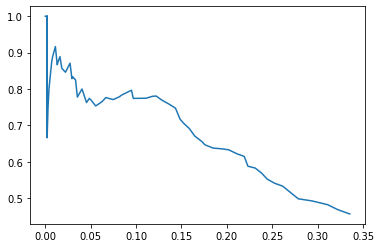

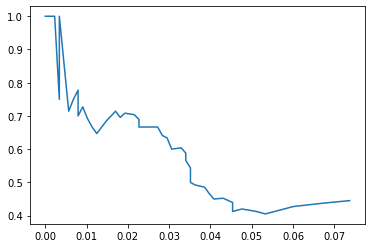

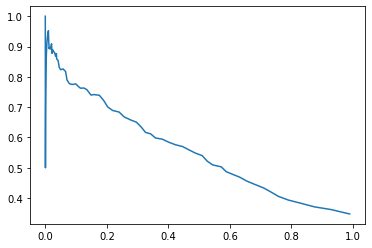

vehicle_ap 0.22371113321849617
person_ap 0.041793164852302646
animal_ap 0.5509070190096184
0.2721370149811341


In [18]:
print(MAP())

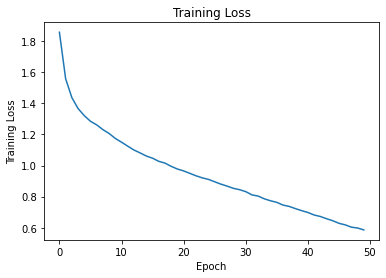

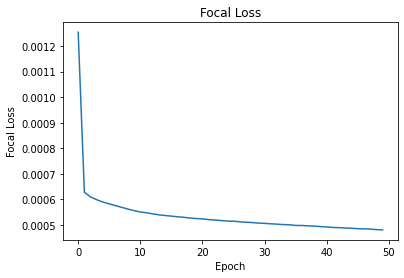

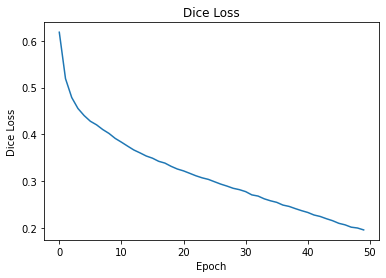

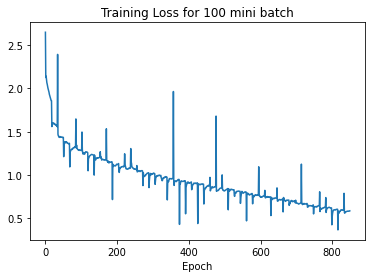

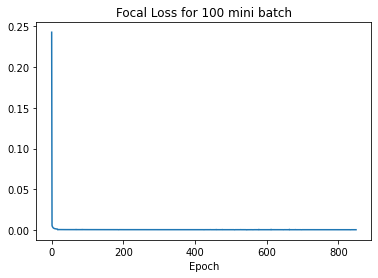

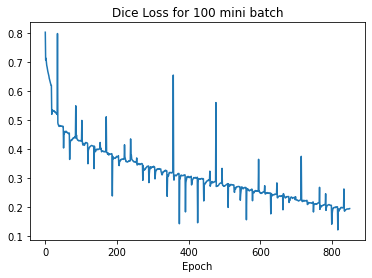

In [19]:
plt.figure()
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(loss_list)

plt.figure()
plt.title("Focal Loss")
plt.xlabel("Epoch")
plt.ylabel("Focal Loss")
plt.plot(focal_loss_list)

plt.figure()
plt.title("Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.plot(dice_loss_list)

plt.figure()
plt.title("Training Loss for 100 mini batch")
plt.xlabel("Epoch")
# plt.ylabel("Training Loss")
plt.plot(loss_list_100)

plt.figure()
plt.title("Focal Loss for 100 mini batch")
plt.xlabel("Epoch")
# plt.ylabel("Focal Loss")
plt.plot(focal_loss_list_100)

plt.figure()
plt.title("Dice Loss for 100 mini batch")
plt.xlabel("Epoch")
# plt.ylabel("Dice Loss")
plt.plot(dice_loss_list_100)